In [1]:
import pandas as pd 
import numpy as np
from sklearn.preprocessing import StandardScaler,RobustScaler,MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

df = pd.read_csv('/Users/varnika/Desktop/harvard/all_var_int.csv')
pd.set_option('display.max_columns', None)

/Users/varnika/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/var/folders/gw/xg9wcgln7x1f2k7qpz6vkm_c0000gn/T/ipykernel_50914/1522025319.py:7: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/varnika/Desktop/harvard/all_var_int.csv')


In [2]:
avalanche_expo_vars = [
    "rugged",            # or slope if you have it
    "elev_mean",         # higher altitude => potential avalanche zone
    "forest_fraction",   # sometimes dense forest can stabilize snow, so less forest => more exposure
    # add any snowfall/winter temperature variables if relevant
]

In [3]:
import pandas as pd

id_cols = ["state_code", "district_code", "block_code", "FID_Key"]
avalanche_expo_cols = id_cols + avalanche_expo_vars

avalanche_expo_df = df[avalanche_expo_cols].copy()

# Check for missing
print(avalanche_expo_df.isna().sum())


state_code         0
district_code      0
block_code         0
FID_Key            0
rugged             0
elev_mean          0
forest_fraction    0
dtype: int64


In [4]:
from sklearn.preprocessing import RobustScaler

Rscaler = RobustScaler()

# Only the chosen exposure columns
features_only = avalanche_expo_df[avalanche_expo_vars].astype(float).values
features_scaled = Rscaler.fit_transform(features_only)

# Create scaled DataFrame
expo_scaled = pd.DataFrame(features_scaled,
                           columns=avalanche_expo_vars,
                           index=avalanche_expo_df.index)

for col in avalanche_expo_vars:
    avalanche_expo_df[col + "_scaled"] = expo_scaled[col]


In [5]:
from sklearn.decomposition import PCA
import numpy as np

expo_pca_vars = [c for c in avalanche_expo_df.columns if c.endswith("_scaled")]
X_expo = avalanche_expo_df[expo_pca_vars].astype(float)

pca = PCA()
pca.fit(X_expo)

# Summarize variance
pcaSummary_aval_expo = pd.DataFrame({
    '% variance': pca.explained_variance_ratio_,
    'Cumulative %': np.cumsum(pca.explained_variance_ratio_)
})
print(pcaSummary_aval_expo.round(3))

   % variance  Cumulative %
0       0.995         0.995
1       0.003         0.998
2       0.002         1.000


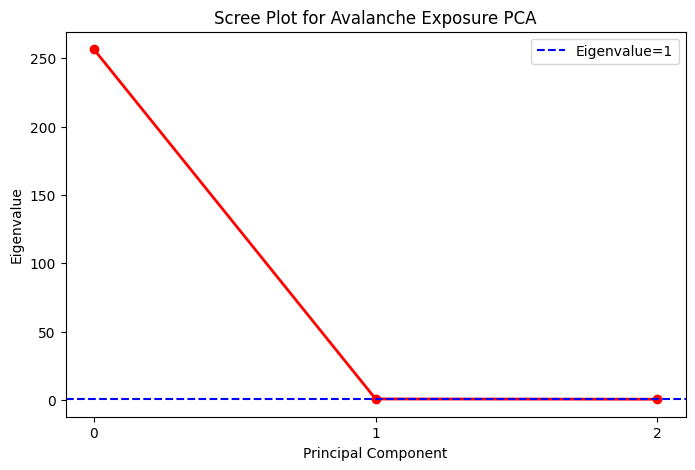

In [6]:
import matplotlib.pyplot as plt

eigenvalues = pca.explained_variance_
xvals = np.arange(len(eigenvalues))

plt.figure(figsize=(8,5))
plt.plot(xvals, eigenvalues, 'ro-', linewidth=2)
plt.title("Scree Plot for Avalanche Exposure PCA")
plt.xlabel("Principal Component")
plt.ylabel("Eigenvalue")
plt.axhline(y=1, color='b', linestyle='--', label="Eigenvalue=1")
plt.xticks(xvals)
plt.legend()
plt.show()


In [7]:
n_components = 2  # or 3
pca_n = PCA(n_components=n_components)
X_expo_pca = pca_n.fit_transform(X_expo)

pca_weights = pcaSummary_aval_expo['% variance'][:n_components]

# Store PC columns
for i in range(n_components):
    avalanche_expo_df[f"AvalExp_PC{i+1}"] = X_expo_pca[:, i]

# Weighted sum => "Avalanche_Exposure_Index"
avalanche_expo_df["Avalanche_Exposure_Index"] = 0
for i in range(n_components):
    avalanche_expo_df["Avalanche_Exposure_Index"] += (
        pca_weights.iloc[i] * avalanche_expo_df[f"AvalExp_PC{i+1}"]
    )

print(avalanche_expo_df[["block_code", "Avalanche_Exposure_Index"]].head())
print(avalanche_expo_df["Avalanche_Exposure_Index"].describe())


   block_code  Avalanche_Exposure_Index
0        6498                  0.332781
1        6492                 -2.903861
2        4689                 -3.692391
3        4690                 -4.613406
4        4692                 -4.541184
count    5.815000e+03
mean     3.128099e-16
std      1.593731e+01
min     -4.739092e+00
25%     -4.712158e+00
50%     -4.637782e+00
75%     -3.645968e+00
max      1.155544e+02
Name: Avalanche_Exposure_Index, dtype: float64


In [8]:
loadings_expo = pd.DataFrame(
    pca_n.components_.T,
    index=expo_pca_vars,
    columns=[f"PC{i+1}" for i in range(n_components)]
)
print(loadings_expo)


                             PC1       PC2
rugged_scaled           0.997063 -0.051878
elev_mean_scaled        0.069618  0.920498
forest_fraction_scaled  0.031908 -0.387288
